In [1]:
import pandas as pd
import seaborn as sns

import matplotlib.pyplot as plt
import plotly.express as px

import numpy as np

from sklearn import linear_model

In [116]:
%run preprocessing.py

In [138]:
#Load in the resampled dataset
df = pd.read_csv('data/processed/hourly_pollutionpatterns.csv').set_index('DATETIME')

pollutants = ["TOC", "TN", "TP", "SS"]
logpollutants = ["logTOC", "logTN", "logTP", "logSS"]
flows = ["Flow", "Bypass"]
rain = ["Rain"]
daily_harmonics = ["sine", "cosine"]
is_weekend = ["is_weekend"]
ones = ["ones"]

#Use the function
df_chunks = adding_remaining_features(df)
fetures_shift = pollutants + flows
df_chunks = dataProcessing_Chunks(df,fetures_shift,6,6)


In [141]:
df = df_chunks.copy()
df.columns

Index(['TOC', 'TN', 'TP', 'SS', 'Flow', 'Bypass', 'Rain', 'sine', 'cosine',
       'ones', 'is_weekend', 'logTOC', 'logTN', 'logTP', 'logSS', 'TOC+1',
       'TOC+2', 'TOC+3', 'TOC+4', 'TOC+5', 'TOC+6', 'TN+1', 'TN+2', 'TN+3',
       'TN+4', 'TN+5', 'TN+6', 'TP+1', 'TP+2', 'TP+3', 'TP+4', 'TP+5', 'TP+6',
       'SS+1', 'SS+2', 'SS+3', 'SS+4', 'SS+5', 'SS+6', 'Flow+1', 'Flow+2',
       'Flow+3', 'Flow+4', 'Flow+5', 'Flow+6', 'Bypass+1', 'Bypass+2',
       'Bypass+3', 'Bypass+4', 'Bypass+5', 'Bypass+6', 'TOC-1', 'TOC-2',
       'TOC-3', 'TOC-4', 'TOC-5', 'TOC-6', 'TN-1', 'TN-2', 'TN-3', 'TN-4',
       'TN-5', 'TN-6', 'TP-1', 'TP-2', 'TP-3', 'TP-4', 'TP-5', 'TP-6', 'SS-1',
       'SS-2', 'SS-3', 'SS-4', 'SS-5', 'SS-6', 'Flow-1', 'Flow-2', 'Flow-3',
       'Flow-4', 'Flow-5', 'Flow-6', 'Bypass-1', 'Bypass-2', 'Bypass-3',
       'Bypass-4', 'Bypass-5', 'Bypass-6'],
      dtype='object')

In [ ]:
from sklearn.preprocessing import PowerTransformer

data = df[pollutants].copy()
data += 1e-8
transformer = PowerTransformer(method="box-cox")
transformed_data = transformer.fit_transform(data)

ddpollutants = []
ddflows = []
for p in pollutants + flows:
    cn = f"dd{p}"
    df[cn] = df[f"{p}+24"] - df[p]
    df[f"{cn}-1"] = df[cn].shift(1)
    if p in pollutants:
        ddpollutants.append(cn)
    if p in flows:
        ddflows.append(cn)

transformed_data = df[ddpollutants + [f"{cn}-1" for cn in ddpollutants] + ddflows + [f"{cn}-1" for cn in ddflows]].copy()
transformed_data.dropna(inplace=True)

df = transformed_data.copy()

#ample = pd.DataFrame(transformed_data[:1000], columns=pollutants)
sample = pd.melt(transformed_data.iloc[:1000,:][ddpollutants].reset_index(), id_vars="DATETIME")
g = sns.FacetGrid(sample, col='variable', col_wrap=2, sharex=False, sharey=False)
g.map(sns.histplot, 'value', kde=True)
g.set_titles("{col_name}")

In [142]:
def get_varnames(steps, variables):
    output = []
    for l in range(*steps):
        if l > 0:
            newcn = lambda x, l: f"{x}+{l}"
        elif l < 0:
            newcn = lambda x, l: f"{x}{l}"
        else:
            newcn = lambda x, l: f"{x}"
        
        output.append([newcn(p, l) for p in variables])
    return [item for sublist in output for item in sublist]

vars_of_interest = pollutants #+ flows
output = get_varnames((1, 2), pollutants)
features = get_varnames((0, 1), vars_of_interest)

print(output)
print(features)

['TOC+1', 'TN+1', 'TP+1', 'SS+1']
['TOC', 'TN', 'TP', 'SS']


In order to make a linear model that predicts one-step ahead and can forecast 6 hours in advance, we would need forecasted inputs (e.g. rain, flow, bypass). For this reason, since this model is supposed to work as a simple benchmark, I decide to exclude them.

In [143]:
#split the sets
train_range = range(20000)
test_range = range(20000, df.shape[0])

dftest = df.iloc[test_range, :]
dftrain = df.iloc[train_range, :]

X_train = dftrain[features]
y_train = dftrain[output]

X_test = dftest[features]
y_test = dftest[output]

In [144]:
reg = linear_model.LinearRegression()
reg.fit(X=X_train, y=y_train)

LinearRegression()

<Axes: >

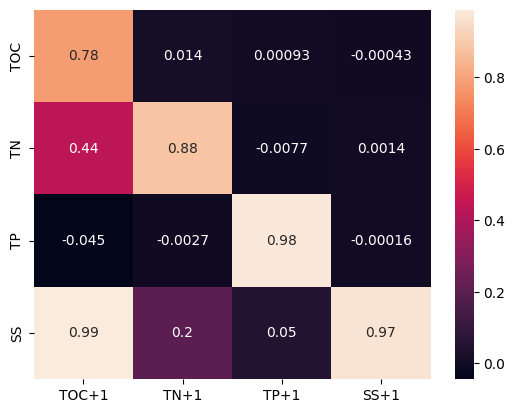

In [145]:
coef_df = pd.DataFrame(reg.coef_.T, columns=output, index=features)
sns.heatmap(coef_df, annot=True)

In [146]:
rmse = lambda x: np.sqrt(np.mean(x**2))
predictions  = reg.predict(X_test)
residuals = reg.predict(X_test) - y_test

for col in residuals:
    print(col, rmse(residuals[col]))

TOC+1 26.334893208730353
TN+1 5.728470219476843
TP+1 4.374792680854668
SS+1 0.18022116609617683


In [147]:
dfplot = y_test.copy()
dfplot["prediction"] = False

dummy = pd.DataFrame(predictions, columns=output, index=dftest.index)
dummy["prediction"] = True

dfplot = pd.concat([dfplot, dummy], axis=0)
dfplot = pd.melt(dfplot.reset_index(), id_vars=["DATETIME", "prediction"], value_vars=output)

In [135]:
fig = px.line(dfplot, x="DATETIME", y="value", facet_row="variable", color="prediction", width=1000, height=600)
fig.update_xaxes(title_text="Pollutant evolution")
fig.update_yaxes(title_text='Value', matches="x")

Not a very good model, since it simply shifts the previous value.

### Suggestions

    - We should normalize the data. TP in particular is very skewed and the linear model assumes normally distributed noise.

In [156]:
dfres = pd.DataFrame(residuals, columns=output, index=df.index[test_range])
px.line(dfres)

In [98]:
px.histogram(dfres)

With the VAR model, I can recursively compute the forecast for the next 6 hours.

In [151]:
mp = np.dot

coefs = reg.coef_
steps_ahead = 6

forecasts = []

for i, row in dftest.iterrows():
    current_concentrations = row[pollutants].values
    forecasted_concentrations = []
    for step in range(1, steps_ahead + 1):
        current_concentrations = mp(coefs, current_concentrations)
        forecasted_concentrations.append(current_concentrations)

    forecasts.append(np.array(forecasted_concentrations))

forecasts = np.array(forecasts)
    

In [152]:
columns = [[f"{p}+{l}" for p in pollutants] for l in range(1, 7)]
columns = [item for sublist in columns for item in sublist]

dfcast = pd.DataFrame(np.reshape(forecasts, (forecasts.shape[0], 24)), index=dftest.index, columns=columns)
dfcast


TOC+1       TN+1      TP+1      SS+1  \
DATETIME                                                               
2023-05-22 10:00:00+00:00  149.087830  46.808360  8.327075  0.335106   
2023-05-22 11:00:00+00:00  155.505326  53.665084  8.967779  0.371650   
2023-05-22 12:00:00+00:00  161.905584  52.746855  9.522350  0.381732   
2023-05-22 13:00:00+00:00  170.481427  52.567253  9.437630  0.361434   
2023-05-22 14:00:00+00:00  178.032736  52.816777  9.748811  0.348092   
...                               ...        ...       ...       ...   
2024-02-20 06:00:00+00:00   51.242895  12.256776  2.071589  0.075941   
2024-02-20 07:00:00+00:00   50.712388  13.262313  1.540186  0.079098   
2024-02-20 08:00:00+00:00   59.529507  15.590984  2.503962  0.142169   
2024-02-20 09:00:00+00:00   68.031521  20.102310  3.783068  0.126200   
2024-02-20 10:00:00+00:00   64.361648  21.238896  2.943459  0.127307   

                                TOC+2       TN+2      TP+2      SS+2  \
DATETIME                                                               
2023-05-22 10:00:00+00:00  137.077458  43.398639  7.997089  0.323177   
2023-05-22 11:00:00+00:00  145.105838  49.544560  8.583359  0.365189   
2023-05-22 12:00:00+00:00  149.696401  48.821875  9.142952  0.370779   
2023-05-22 13:00:00+00:00  156.310689  48.776360  9.067821  0.347198   
2023-05-22 14:00:00+00:00  162.300416  49.096042  9.378690  0.331322   
...                               ...        ...       ...       ...   
2024-02-20 06:00:00+00:00   45.434714  11.528250  1.997544  0.067926   
2024-02-20 07:00:00+00:00   45.486521  12.410698  1.466190  0.072696   
2024-02-20 08:00:00+00:00   53.422733  14.596858  2.408803  0.132919   
2024-02-20 09:00:00+00:00   61.975182  18.688403  3.641033  0.119899   
2024-02-20 10:00:00+00:00   59.640039  19.644124  2.802146  0.124284   

                                TOC+3       TN+3  ...      TP+4      SS+4  \
DATETIME                                          ...                       
2023-05-22 10:00:00+00:00  126.192320  40.223426  ...  7.394286  0.301841   
2023-05-22 11:00:00+00:00  135.177774  45.765131  ...  7.894135  0.349678   
2023-05-22 12:00:00+00:00  138.433444  45.189448  ...  8.454283  0.349601   
2023-05-22 13:00:00+00:00  143.568135  45.234848  ...  8.389761  0.322592   
2023-05-22 14:00:00+00:00  148.364390  45.594647  ...  8.694342  0.304005   
...                               ...        ...  ...       ...       ...   
2024-02-20 06:00:00+00:00   40.567380  10.804506  ...  1.853138  0.056795   
2024-02-20 07:00:00+00:00   41.022488  11.586573  ...  1.326175  0.063478   
2024-02-20 08:00:00+00:00   48.205308  13.634394  ...  2.227916  0.118795   
2024-02-20 09:00:00+00:00   56.618545  17.356802  ...  3.378087  0.109747   
2024-02-20 10:00:00+00:00   55.251678  18.171739  ...  2.548224  0.118105   

                                TOC+5       TN+5      TP+5      SS+5  \
DATETIME                                                               
2023-05-22 10:00:00+00:00  107.254175  34.527868  7.119431  0.292098   
2023-05-22 11:00:00+00:00  116.889681  39.098840  7.584411  0.341151   
2023-05-22 12:00:00+00:00  118.438938  38.718022  8.141702  0.339352   
2023-05-22 13:00:00+00:00  121.601758  38.860123  8.079730  0.311662   
2023-05-22 14:00:00+00:00  124.769758  39.242602  8.379451  0.292496   
...                               ...        ...       ...       ...   
2024-02-20 06:00:00+00:00   32.900150   9.417584  1.784274  0.052875   
2024-02-20 07:00:00+00:00   33.805578  10.047474  1.260976  0.060076   
2024-02-20 08:00:00+00:00   39.767571  11.835847  2.143160  0.113231   
2024-02-20 09:00:00+00:00   47.566487  14.939102  3.256969  0.105514   
2024-02-20 10:00:00+00:00   47.396789  15.555647  2.434125  0.114995   

                                TOC+6       TN+6      TP+6      SS+6  
DATETIME                                                              
2023-05-22 10:00:00+00:00   98.987527  31.982202  6.860887  0.282818  
2023-0

In [149]:
dftest.shape

(6526, 87)

In [155]:
for p in pollutants:
    cn = f"{p}+6"
    res_by_pollutant = (dfcast[cn] - dftest[cn])
    print(rmse(res_by_pollutant))

65.74113895558715
15.310169475327516
7.029459724229469
0.3356119058191858
